In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages
import os
import pickle
from tensorly.decomposition import non_negative_parafac

import tensorflow as tf
cpu_devices = tf.config.list_physical_devices("CPU")
tf.config.set_visible_devices(cpu_devices)

2025-07-28 21:18:25.770132: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-28 21:18:25.777021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753708705.785266   34286 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753708705.787572   34286 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753708705.793716   34286 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
session_folder = os.listdir("/media/ubuntu/sda/neuropixels/output_dir")
session_list = []
for session in session_folder:
    if 'session_' in session:
        session_list.append(session)

In [3]:
# cluster_inf_all = pd.DataFrame()
# activity_dict = {}

# for session in session_list:
#     output_dir = f'/media/ubuntu/sda/neuropixels/output_dir/{session}'
#     cluster_inf = pd.read_csv(f'{output_dir}/cluster_inf.csv')
#     spike_inf = pd.read_csv(f'{output_dir}/spike_inf_static_gratings.csv', index_col=0)
#     stimulus_table = pd.read_csv(f'{output_dir}/stimulus_table_static_gratings.csv')
#     stimulus_table = stimulus_table[~stimulus_table['orientation'].isna()]
    
#     stimulus_table['orientation_phase_frequency'] = (
#         stimulus_table['orientation'].astype(str) + '_' + 
#         stimulus_table['phase'].astype(str) + '_' + 
#         stimulus_table['spatial_frequency'].astype(str)
#     )

#     filtered_spikes = spike_inf['id'].value_counts()
#     filtered_spikes = filtered_spikes[filtered_spikes > 30000].index
#     cluster_inf = cluster_inf[cluster_inf['unit_id'].isin(filtered_spikes)]
#     spike_inf = spike_inf[spike_inf['id'].isin(filtered_spikes)]

#     cluster_inf_all = pd.concat((cluster_inf_all, cluster_inf), axis = 0)

#     for neuron in cluster_inf['unit_id']:
#         spike_inf_temp = spike_inf[spike_inf['id'] == neuron]
#         neuron = f'{neuron}_{session}'
#         activity_dict[neuron] = {}
#         for image in stimulus_table['orientation_phase_frequency'].unique():
#             activity_dict[neuron][image] = []

#             trigger_time_temp = stimulus_table[(stimulus_table['orientation_phase_frequency'] == image)]

#             for index, row in trigger_time_temp.iterrows():
#                 start = row['start_time']
#                 end = row['stop_time']

#                 filtered_spikes = spike_inf_temp[(spike_inf_temp['time'] >= start) &
#                                                 (spike_inf_temp['time'] <= end)]
#                 if not filtered_spikes.empty:
#                     relative_spikes = (filtered_spikes['time'] - start) * 1000
#                     activity_dict[neuron][image].append(np.array(relative_spikes))

In [5]:
#cluster_inf_all.to_csv("/media/ubuntu/sda/neuropixels/grating/cluster_inf_all_grating.csv")

In [ ]:
# with open("/media/ubuntu/sda/neuropixels/grating/activity_dict_all_grating_30000.pkl", 'wb') as f:
#     pickle.dump(activity_dict, f)

In [3]:
with open("/media/ubuntu/sda/neuropixels/grating/activity_dict_all_grating_30000.pkl", 'rb') as f:
    activity_dict = pickle.load(f)

In [4]:
cluster_inf_all = pd.read_csv("/media/ubuntu/sda/neuropixels/grating/cluster_inf_all_grating.csv", index_col=0)

In [5]:
def getResponseCurve(train_dict, total_trial_len, bw=None, samp_interval=1, MINBW=10, MAXBW=50):
    """Computes smooth trial-averaged response to a stim in all directions from spike trains
    using a kernel density estimator, with per-trial KDE averaging."""

    ts = np.arange(0, total_trial_len + samp_interval, samp_interval)
    x_ts = 0.5 * (ts[:-1] + ts[1:])  # sample at the midpoints

    # Determine global bandwidth if not provided
    global_bw = bw
    if global_bw is None:
        # Find first non-empty trial to determine bandwidth
        for d in sorted(train_dict):
            for train in train_dict[d]:
                if train.size > 0:
                    temp_kde = FFTKDE(kernel='gaussian', bw=None).fit(train)
                    global_bw = temp_kde.bw
                    # Apply bandwidth constraints
                    global_bw = max(MINBW, min(global_bw, MAXBW))
                    break
            if global_bw is not None:
                break
        # If no spikes found in any trial, use default bandwidth
        if global_bw is None:
            global_bw = (MINBW + MAXBW) / 2

    all_ISJs = []
    
    for d in sorted(train_dict):
        trial_responses = []  # Store KDE results for each trial in this direction
        
        for train in train_dict[d]:
            if train.size == 0:
                # Handle empty trials with zero array
                y_trial = np.zeros_like(x_ts)
                trial_responses.append(y_trial)
                continue
                
            try:
                # Create KDE for this single trial
                ext_x_ts = np.r_[x_ts[0]-samp_interval, x_ts, x_ts[-1]+samp_interval]
                fftkde = FFTKDE(kernel='gaussian', bw=global_bw).fit(train)
                y_density = fftkde.evaluate(ext_x_ts)[1:-1]  # crop extended regions
                
                # Convert to firing rate (spikes/sec)
                y_trial = y_density * len(train) * 1000
                trial_responses.append(y_trial)
                
            except Exception as e:
                print(f'KDE failed for direction {d}, trial with {len(train)} spikes: {str(e)}')
                #trial_responses.append(np.zeros_like(x_ts))
        
        # Average all trials for this direction
        avg_response = np.mean(trial_responses, axis=0)
        all_ISJs.append(avg_response)
        
    return np.array(all_ISJs), x_ts

In [6]:
activity_dict_region = {}
filtered_neuron = {}
for region in ['VISp', 'VISal', 'VISam', 'VISrl', 'VISpm', 'VISl']:
    activity_dict_region[region] = {}
    cluster_inf_temp = cluster_inf_all[cluster_inf_all['ecephys_structure_acronym'] == region]
    filtered_neuron[region] = cluster_inf_temp['unit_id'].values

    for key, item in activity_dict.items():
        key = key.split("_")[0]
        if int(key) in filtered_neuron[region]:
            activity_dict_region[region][key] = item


In [55]:
all_waveform = pd.read_csv("all_waveform.csv", index_col=0)
all_waveform = all_waveform.loc[filtered_neuron['VISp']]

from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.cluster import KMeans
pca = PCA(n_components=10)
umap = UMAP(n_components=2)
kmeans = KMeans(n_clusters=2,random_state=40)
all_waveform_pca = pca.fit_transform(all_waveform)
all_waveform_umap = umap.fit_transform(all_waveform_pca[:, :10])
cluster_label = kmeans.fit_predict(all_waveform_umap)
all_waveform['cluster'] = cluster_label

from prinpy.glob import NLPCA
pca = NLPCA()
pca.fit(all_waveform_umap, epochs = 150, nodes = 15, lr = .01, verbose = 0)
proj, curve_pts = pca.project(all_waveform_umap)

I0000 00:00:1753710474.381007   36856 service.cc:152] XLA service 0x7f45fc00c400 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753710474.381060   36856 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-07-28 21:47:54.409128: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753710474.607045   36856 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [58]:
proj.shape

(657, 1)

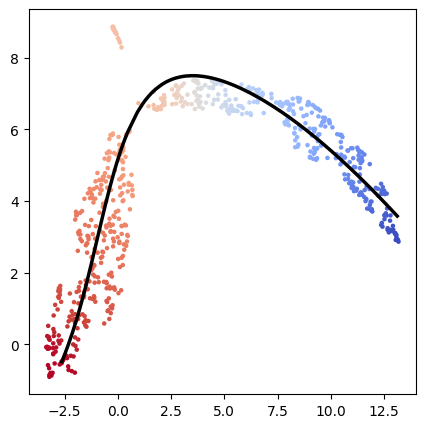

In [56]:
plt.figure(figsize=(5, 5))
plt.scatter(all_waveform_umap[:,0], 
        all_waveform_umap[:,1], 
        s = 5, 
        c = -proj.reshape(-1), 
        cmap = 'coolwarm')

plt.plot(curve_pts[:,0], 
        curve_pts[:,1], 
        color = 'black',
        linewidth = '2.5')

In [7]:
with open("/media/ubuntu/sda/neuropixels/grating/activity_region.pkl", 'rb') as f:
    activity_df = pickle.load(f)

In [8]:
stimulus_df = pd.DataFrame(activity_dict_region['VISal']['915964501'].keys(), columns=['id'])
stimulus_df['orientation'] = None
stimulus_df['phase'] = None
stimulus_df['frequency'] = None
for i in range(len(stimulus_df)):
    stimulus_df.loc[i, 'orientation'], stimulus_df.loc[i, 'phase'], stimulus_df.loc[i, 'frequency'] = stimulus_df.loc[i, 'id'].split("_")


In [9]:
for key, array in activity_df.items():
    if array.shape[2] != len(stimulus_df):
        raise ValueError(f"维度不匹配: {key}")
    
    transposed = np.transpose(array, (2, 0, 1))
    
    stimulus_df[key] = list(transposed)

In [10]:
stimulus_df['orientation'] = stimulus_df['orientation'].astype(float)
stimulus_df['phase'] = stimulus_df['phase'].astype(float)
stimulus_df['frequency'] = stimulus_df['frequency'].astype(float)

stimulus_df = stimulus_df.sort_values(by=['frequency', 'orientation', 'phase'])

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
from pydiffmap import diffusion_map

with PdfPages("/media/ubuntu/sda/neuropixels/grating/response_heatmap.pdf") as pdf:
    for i in range(len(stimulus_df)):
        response_matrix = stimulus_df['VISp'].values[i].astype(np.float32)
        neuron_means = np.mean(response_matrix, axis=1, keepdims=True)
        neuron_stds = np.std(response_matrix, axis=1, keepdims=True)
        response_matrix_z = (response_matrix - neuron_means) / (neuron_stds + 1e-8)

        n_components = 15  
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        svd_components = svd.fit_transform(response_matrix_z)

        explained_variance = svd.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)


        n_effective = np.argmax(cumulative_variance >= 0.95) + 1

        dm = diffusion_map.DiffusionMap.from_sklearn(n_evecs = 3, epsilon = 1.0, alpha = 0.5, k=32)
        diffusion_coordinates = dm.fit_transform(svd_components)

        neuron_inf = pd.DataFrame(filtered_neuron['VISp'], columns=['id'])
        neuron_inf = pd.concat((neuron_inf, pd.DataFrame(diffusion_coordinates)), axis=1)
        neuron_inf['activity'] = list(response_matrix_z)

        fig, axes = plt.subplots(1, 3, figsize = (8, 6))
        axes = axes.flatten()
        for order in [0, 1, 2]:
            ax = axes[order]
            neuron_inf = neuron_inf.sort_values(by=order)
            sns.heatmap(np.stack(neuron_inf['activity'].values), cmap='coolwarm', ax=ax, cbar=False)
            
        fig.suptitle(stimulus_df['id'].values[i])
        pdf.savefig()
        plt.close()

In [83]:
temp = stimulus_df
temp = temp.sort_values(by=['frequency', 'orientation', 'phase'])
temp_df = np.stack(temp['VISp'].values, axis=2)
for i in range(len(temp_df)):
    min_val = temp_df[i, :, :].min()
    max_val = temp_df[i, :, :].max()

    temp_df[i, :, :] = (temp_df[i, :, :] - min_val)/(max_val - min_val)
    #temp_df[i, :, :] = temp_df[i, :, :] / max_val

import tensorly as tl
from sklearn.decomposition import PCA
from pydiffmap import diffusion_map
from sklearn.metrics.pairwise import pairwise_distances, rbf_kernel

factors = non_negative_parafac(
    temp_df, 
    rank=60,
    init='random',
    n_iter_max=500,
    tol=1e-6
)

neural_matrix = factors.factors[0]
norms = [tl.norm(f, 2) for f in factors.factors]
lambda_vec = factors.weights * np.prod(norms, axis=0)
neural_scaled = neural_matrix * lambda_vec

neural_pca = PCA(n_components=0.8).fit_transform(neural_scaled)
gamma = 1.0 / np.median(pairwise_distances(neural_pca))**2
sim_matrix = rbf_kernel(neural_pca, gamma=gamma)

dm = diffusion_map.DiffusionMap.from_sklearn(n_evecs = 5, epsilon = 1.0, alpha = 0.5, k=64)
diffusion_coordinates = dm.fit_transform(sim_matrix)

In [84]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=diffusion_coordinates[:, 0],
    y=diffusion_coordinates[:, 1],
    z=diffusion_coordinates[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color = all_waveform_umap[:, 0],
        colorscale = 'blues',
        colorbar=dict(
            title='Excitatory Score'
        )
    ),
    name='Neurons'
))

fig.update_layout(
    title='3D Neuron Distribution (Gray: score<0.5)',
    scene=dict(
        xaxis_title='Diffusion Axis 1',
        yaxis_title='Diffusion Axis 2',
        zaxis_title='Diffusion Axis 3',
        camera=dict(eye=dict(x=1.5, y=1, z=0.1))
    ),
    width=800,
    height=600
)

fig.show()

In [11]:
activity = np.stack(stimulus_df['VISp'].values, axis=2)

In [143]:
response_matrix = activity[12, :, :].T
neuron_means = np.mean(response_matrix, axis=1, keepdims=True)
neuron_stds = np.std(response_matrix, axis=1, keepdims=True)
response_matrix_z = (response_matrix - neuron_means) / (neuron_stds + 1e-8)

n_components = 15  
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd_components = svd.fit_transform(response_matrix_z)

explained_variance = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


n_effective = np.argmax(cumulative_variance >= 0.95) + 1

dm = diffusion_map.DiffusionMap.from_sklearn(n_evecs = 3, epsilon = 1.0, alpha = 0.5, k=32)
diffusion_coordinates = dm.fit_transform(svd_components)

In [37]:
response_matrix_z.shape

(657, 26)

In [43]:
neuron_inf = pd.DataFrame(filtered_neuron['VISp'], columns=['id'])
neuron_inf = pd.concat((neuron_inf, pd.DataFrame(diffusion_coordinates)), axis=1)
neuron_inf['activity'] = list(np.stack(temp['VISp'].values, axis=2))

In [44]:
neuron_inf = neuron_inf.sort_values(by=0)

In [29]:
def cal_OSI(neuron_inf):
    index_map = {
        0:4,
        1:-1,
        2:3,
        4:0,
        5:1,
        3:2
    }
    for i in range(len(neuron_inf)):
        activity = neuron_inf['activity'].values[i]
        mean_activity = activity.mean(axis = 0)
        activity_index = np.argmax(mean_activity)
        R_ref = mean_activity[activity_index]
        R_orth = mean_activity[index_map[activity_index]]
        OSI = (R_ref - R_orth) / (R_ref + R_orth)
        neuron_inf['OSI'].values[i] = OSI

In [181]:
with PdfPages("/media/ubuntu/sda/neuropixels/grating/neuron_activity.pdf") as pdf:
    neuron_inf = neuron_inf.sort_values(by=0)
    for neuron in range(0, len(neuron_inf), 5):
        fig, axes = plt.subplots(3, 2, figsize=(10, 8))
        axes = axes.flatten()

        activity = neuron_inf['activity'].values[neuron]
        activity_max = activity.max()
        activity = activity / activity_max
        orientation_labels = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0]  

        for i in range(5):
            ax = axes[i]
            temp = activity[:, i * 6 : (i + 1) * 6]
            
            temp_transposed = temp.T
            
            sns.heatmap(temp_transposed, ax=ax, vmax=1.0, vmin=0)
            
            ax.set_yticks(np.arange(6))
            ax.set_yticklabels(orientation_labels)
            ax.set_ylabel("Orientation (deg)")
            
            ax.set_title(f"Frequency Group {i+1}")
        
        plt.title(neuron)
        plt.tight_layout()
        pdf.savefig()
        plt.close()

In [85]:
from scipy.stats import entropy, norm
neuron_inf['entropy'] = None
def cal_entrophy(neuron_inf):
    for i in range(len(neuron_inf)):
        activity = neuron_inf['activity'].values[i]
        max_time = np.argmax(activity, axis = 0)
        hist, _ = np.histogram(max_time, bins=15, density=True, range=(1, 26))
        hist = hist / hist.sum()

        time_points = np.linspace(0, 26, 15)
        ref_dist = norm.pdf(time_points, loc=5, scale=2)  
        ref_dist = ref_dist / ref_dist.sum()

        kl_divergence = entropy(hist, ref_dist)


        neuron_inf['entropy'].values[i] = kl_divergence
cal_entrophy(neuron_inf)

In [113]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=diffusion_coordinates[:, 0],
    y=diffusion_coordinates[:, 1],
    z=diffusion_coordinates[:, 2],
    mode='markers',
    marker=dict(
        size=4
    ),
    name='Neurons'
))

fig.update_layout(
    title='3D Neuron Distribution (Gray: score<0.5)',
    scene=dict(
        xaxis_title='Diffusion Axis 1',
        yaxis_title='Diffusion Axis 2',
        zaxis_title='Diffusion Axis 3',
        camera=dict(eye=dict(x=1.5, y=1, z=0.1))
    ),
    width=800,
    height=600
)

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=diffusion_coordinates[:, 0],
    y=diffusion_coordinates[:, 1],
    z=diffusion_coordinates[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        colorscale=[[0, '#DCDCDC'], [0.5, '#DCDCDC'], [0.5001, 'rgb(200,200,255)'], [1, 'rgb(0,0,255)']],
        cmin=0,
        cmax=1,
        opacity=1,
        color=all_waveform['excitatory_score'],
        colorbar=dict(
            title='Excitatory Score',
            tickvals=[0.25, 0.75],
            ticktext=['<0.5', '≥0.5'],
            lenmode='fraction',
            len=0.75
        )
    ),
    name='Neurons'
))

fig.update_layout(
    title='3D Neuron Distribution (Gray: score<0.5)',
    scene=dict(
        xaxis_title='Diffusion Axis 1',
        yaxis_title='Diffusion Axis 2',
        zaxis_title='Diffusion Axis 3',
        camera=dict(eye=dict(x=1.5, y=1, z=0.1)),
        # 移除网格线和背景颜色
        xaxis=dict(
            showgrid=False,  # 移除X轴网格
            backgroundcolor="rgba(0,0,0,0)",  # 透明背景
            showbackground=False  # 移除背景
        ),
        yaxis=dict(
            showgrid=False,  # 移除Y轴网格
            backgroundcolor="rgba(0,0,0,0)",
            showbackground=False
        ),
        zaxis=dict(
            showgrid=False,  # 移除Z轴网格
            backgroundcolor="rgba(0,0,0,0)",
            showbackground=False
        ),
        bgcolor='rgba(0,0,0,0)'  # 整个场景透明背景
    ),
    width=800,
    height=600,
    plot_bgcolor='rgba(0,0,0,0)',  # 绘图区域透明背景
    paper_bgcolor='rgba(0,0,0,0)'  # 整个图表透明背景
)

fig.show()

In [93]:
print(fig.layout.scene.camera)

layout.scene.Camera({
    'eye': {'x': 1.5, 'y': 1.5, 'z': 0.1}
})


In [323]:
activity = neuron_inf['activity'].values[i]
mean_activity = activity.mean(axis = 0)